In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='white', hemi='both', cortex='low_contrast', verbose=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
info = get_info(kind='biosemi32')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

No projector specified for this dataset. Please consider the method self.add_proj.


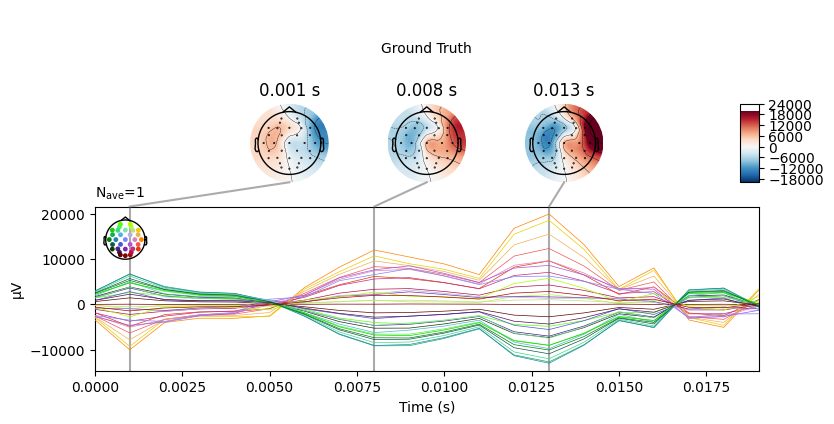

Using control points [0.         0.         0.00517201]


In [97]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=2,
    n_orders=(1, 1),
    snr_range=(1e99, 2e99),
    n_timecourses=200,
    n_timepoints=20,
    diffusion_parameter=0.15,
    scale_data=False)

gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Algo

## Prepare Basis functions

In [88]:
import numpy as np
from scipy.sparse import coo_matrix

def cotangent_weight(v1, v2, v3):
    # Compute the cotangent weight of the edge opposite to v1
    edge1 = v2 - v1
    edge2 = v3 - v1
    cotangent = np.dot(edge1, edge2) / np.linalg.norm(np.cross(edge1, edge2))
    return cotangent

def compute_laplace_beltrami(pos, faces):
    n = pos.shape[1]  # Number of vertices
    I = []
    J = []
    V = []
    
    for face in faces:
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            
            vi = pos[:, face[i]]
            vj = pos[:, face[j]]
            vk = pos[:, face[k]]
            
            # Compute cotangent weights for edges (vi, vj) and (vi, vk)
            cot_jk = cotangent_weight(vi, vj, vk)
            cot_kj = cotangent_weight(vi, vk, vj)
            
            # Update the entries for the Laplacian matrix
            I.append(face[i])
            J.append(face[j])
            V.append(-0.5 * (cot_jk + cot_kj))
            
            # Add the contribution to the diagonal element
            I.append(face[i])
            J.append(face[i])
            V.append(0.5 * (cot_jk + cot_kj))
    
    # Create the sparse Laplacian matrix
    L = coo_matrix((V, (I, J)), shape=(n, n))
    
    return L

# Example usage
n_vertices_left = fwd['src'][0]['nuse']
faces = np.concatenate([
    fwd['src'][0]['use_tris'],
    n_vertices_left + fwd['src'][1]['use_tris'],
], axis=0)

pos = pos_from_forward(fwd)
A = compute_laplace_beltrami(pos.T, faces)
_, eigenvalues, _ = np.linalg.svd(A.toarray(), full_matrices=False)
Sigma = np.diag(1 / (eigenvalues + 0.1 * np.mean(eigenvalues)))
Sigma_inv = np.linalg.inv(Sigma)

## Compute

In [98]:
Y = evoked.data

K = fwd["sol"]["data"]
K /= np.linalg.norm(K, axis=0)  # Normalize the leadfield
L = K @ A

# # plot basis functions
# stc_ = stc.copy()
# stc_.data = A.toarray()
# brain = stc_.plot(brain_kwargs=dict(title="Basis Functions"), **pp)

# Inverse minimum norm
beta = 1e-6
J = K.T @ np.linalg.inv(K @ K.T + beta * np.eye(K.shape[0])) @ Y
J /= np.linalg.norm(J)
stc_ = stc.copy()
stc_.data = J
brain = stc_.plot(brain_kwargs=dict(title="MNE"), **pp)

# Inverse GBF
beta = 1e-6
J = np.linalg.inv(L.T @ L + beta * Sigma_inv) @ L.T @ Y

J /= np.linalg.norm(J)

stc_ = stc.copy()
stc_.data = J
brain = stc_.plot(brain_kwargs=dict(title="GBF"), **pp)

Using control points [0.00597332 0.00744393 0.02741942]
Using control points [0.00589706 0.00738806 0.0281375 ]
